In [1]:
import requests

url = "http://localhost:8000/detect"
image_path = "../resources/images/4.jpg"


with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

if response.status_code == 200:
    result = response.json()
    print("Обнаруженные боксы:")
    for box in result["boxes"]:
        print(box)
else:
    print("Ошибка:", response.status_code, response.text)


Обнаруженные боксы:
{'x1': 183, 'y1': 63, 'x2': 471, 'y2': 230}


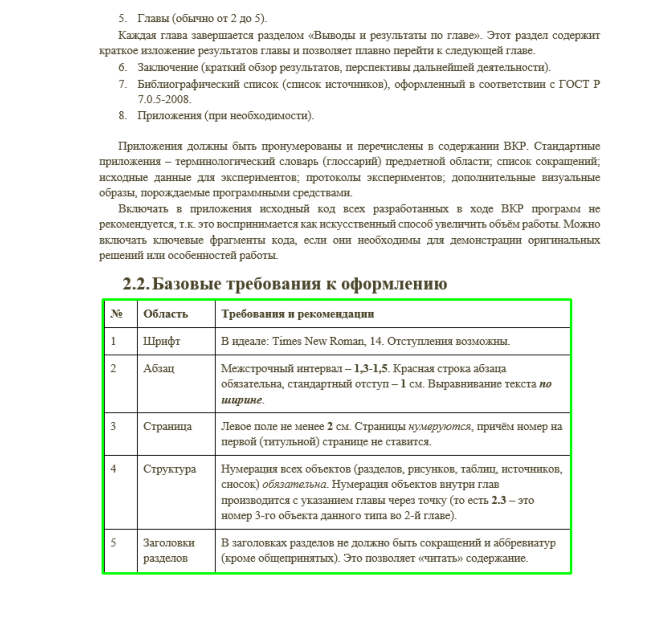

In [28]:
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

image_path = "../resources/images/6.png"
url = "http://localhost:8000/detect"

with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

result = response.json()
boxes = result.get("boxes", [])

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in boxes:
    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# Service Usage

In [ ]:
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd

from RecognitionService.ocr_enums import OCREngine, OCRLang

# Пути и настройки
image_path = "../resources/images/6.png"
detect_url = "http://localhost:8000/detect"
recognize_url = "http://localhost:8001/recognize"

image = cv2.imread(image_path)

with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    detect_response = requests.post(detect_url, files=files)

detect_response.raise_for_status()
boxes = detect_response.json()["boxes"]

results = []
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

    # Вырезаем ROI и кодируем в память
    roi = image[y1:y2, x1:x2]
    is_success, buffer = cv2.imencode(".jpg", roi)
    if not is_success:
        print(f"Ошибка при кодировании ROI {i}")
        continue

    roi_bytes = BytesIO(buffer.tobytes())

    files = {"file": ("cell.jpg", roi_bytes, "image/jpeg")}
    params = {"lang": OCRLang.rus, "engine": OCREngine.tesseract}
    rec_response = requests.post(recognize_url, files=files, params=params)

    if rec_response.status_code == 200:
        data = rec_response.json()
        results.append(data.get("table", []))
    else:
        print(f"[Ошибка OCR: {rec_response}]")
        print(rec_response.content)


AttributeError: type object 'OCRLang' has no attribute 'ru'

In [3]:
pd.DataFrame(results[0])

,0,1,2
0,№,Область,Требования и рекомендации
1,1,Шрифт,"В идеале: Типез Меуу Котал, 14. Отступления во..."
2,2,Абзац,"Межстрочный интервал — 1,3-1,5. Красная строка..."
3,3,Страница,"Левое поле не менее 2 см. Страницы нумеруются,..."
4,4,Структура,"Нумерация всех объектов (разделов, рисунков, т..."
5,5,Заголовки\nразделов,В заголовках разделов не должно быть сокращени...


In [18]:
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt

from RecognitionService.ocr_enums import OCREngine, OCRLang

def get_table_data(image_path: str, correct_text: bool = True):
    detect_url = "http://localhost:8000/detect"
    recognize_url = "http://localhost:8001/recognize"

    image = cv2.imread(image_path)

    with open(image_path, "rb") as f:
        files = {"file": (image_path, f, "image/jpeg")}
        detect_response = requests.post(detect_url, files=files)

    detect_response.raise_for_status()
    boxes = detect_response.json()["boxes"]

    results = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        # Вырезаем ROI и кодируем в память
        roi = image[y1:y2, x1:x2]
        is_success, buffer = cv2.imencode(".jpg", roi)
        if not is_success:
            print(f"Ошибка при кодировании ROI {i}")
            continue

        roi_bytes = BytesIO(buffer.tobytes())

        files = {"file": ("cell.jpg", roi_bytes, "image/jpeg")}
        params = {"lang": OCRLang.rus, "engine": OCREngine.tesseract, "correct_text": correct_text}
        rec_response = requests.post(recognize_url, files=files, params=params)

        if rec_response.status_code == 200:
            data = rec_response.json()
            df = pd.DataFrame(data.get("table", []))
            results.append(df)
        else:
            print(f"[Ошибка OCR: {rec_response}]")
            print(rec_response.content)
            
        return results
    
def show_image(image_path: str):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()
    
def show_and_get_tables(image_path: str, correct_text: bool = True):
    try:
        show_image(image_path)
        results = get_table_data(image_path, correct_text)
        print(f"count of tables: {len(results)}")
        return results
            
    except Exception as e:
        print(e)

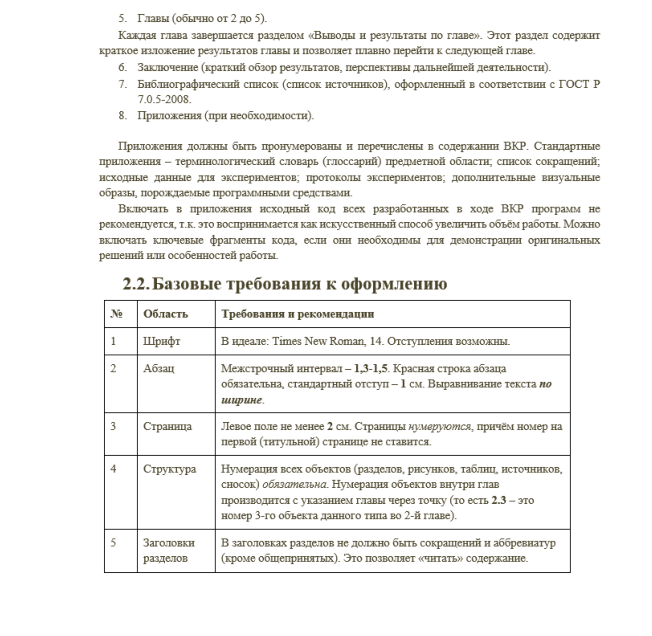

count of tables: 1


,0,1,2
0,№,Область,Требования и рекомендации
1,1,Шрифт,"В идеале: Типез Меуу Котал, 14. Отступления во..."
2,2,Абзац,"Межстрочный интервал — 1,3-1,5. Красная строка..."
3,3,Страница,"Левое поле не менее 2 см. Страницы нумеруются,..."
4,4,Структура,"Нумерация всех объектов (разделов, рисунков, т..."
5,5,Заголовки\nразделов,В заголовках разделов не должно быть сокращени...


In [25]:
res = show_and_get_tables("../resources/images/6.png", False)

res[0]

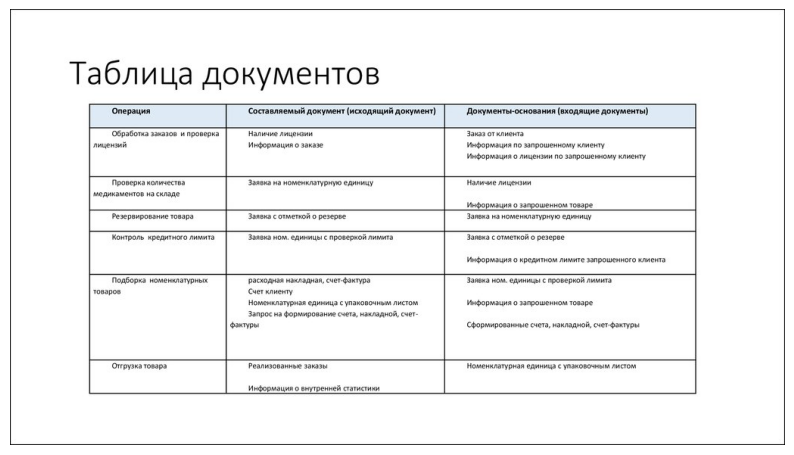

count of tables: 1


,0,1,2
0,Операция,Составляемый документ (исходящий документ).,Документы-основания. Входящие документы.
1,Обработка заказов и проверка лицензий.,"Наличие лицензии, информация о заказе.",Заказ от клиента: информация по запрошенному к...
2,Проверка количества медикаментов на складе.,Скидка на номенклатурную единицу.,"Наличие лицензии, информация о запрошенном тов..."
3,Резервирование товара.,Заявка с отметкой о резерве.,Заявка на номенклатурную единицу.
4,Контроль кредитного лимита.,Заявка на импорт единицы с проверкой лимита.,Заявка с отметкой о резерве. Информация о кред...
5,Подборка номенклатурных товаров.,"Расходная накладная, счет-фактура. Счет клиент...",Заявка на импорт единицы с проверкой лимита. И...
6,Отгрузка товара.,Реализованные заказы. Информация о внутренней ...,Номенклатурная единица с упаковочным листом.


In [20]:
res = show_and_get_tables("../resources/images/7.jpg")

res[0]

In [35]:
res[0].to_csv("test_1.csv", encoding="utf-8-sig", index=False, sep=";")

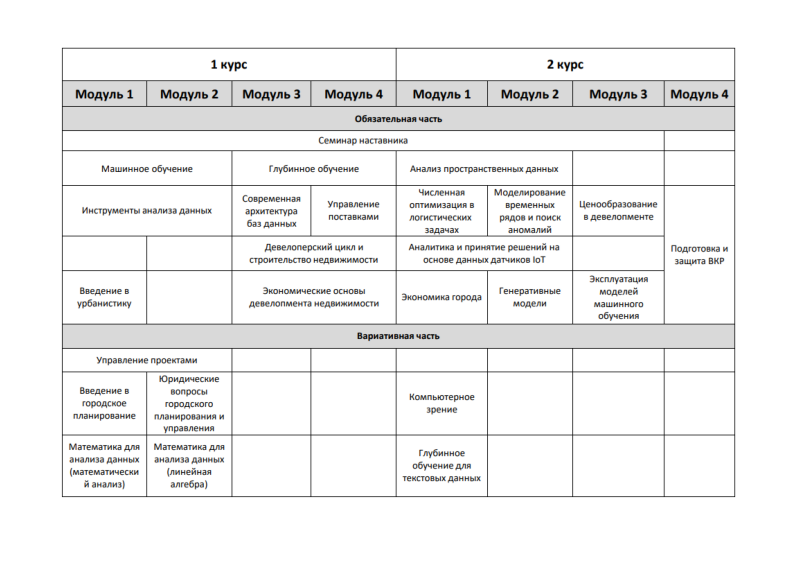

count of tables: 1


,0,1,2,3,4,5,6
0,1 курс,,,,,,
1,Модуль 1,Модуль 2,Модуль 3,Модуль 4,Модуль 1,Модуль 2,Модуль 3
2,Семинар наставника,,,,,,
3,Машинное обучение,Глубинное обучение,Анализ пространственных данных,|,,,
4,Инструменты анализа данных,Современная\nархитектура\nбаз данных,Управление\nпоставками,Численная\nоптимизация в\nлогистических\n\nзад...,Моделирование\nвременных\nрядов и поиск\nаномалий,Ценообразование\nв девелопменте,
5,,,Девелоперский цикл и\nстроительство недвижимости,Аналитика и принятие решений на\nоснове данных...,,,
6,Введение в\nурбанистику,й *\n. р,Экономические основы\nдевелопмента недвижимости,Экономика города,Генеративные\nмодели,Эксплуатация\nмоделей\nмашинного\nобучения,
7,Управление проектами,,ый ь,,”* .,| |,
8,Введение в\nгородское\nпланирование,Юридические\nвопросы\nгородского\nпланирования...,,,Компьютерное\nзрение,д |,о
9,Математика для\n\nанализа данных\n\n(математич...,Математика для\nанализа данных\n(линейная\nалг...,,;: Е,Глубинное\nобучение для\nтекстовых данных,у |,|


In [ ]:
res = show_and_get_tables("../resources/images/8.png",)

res[0]

Получено страниц: 1


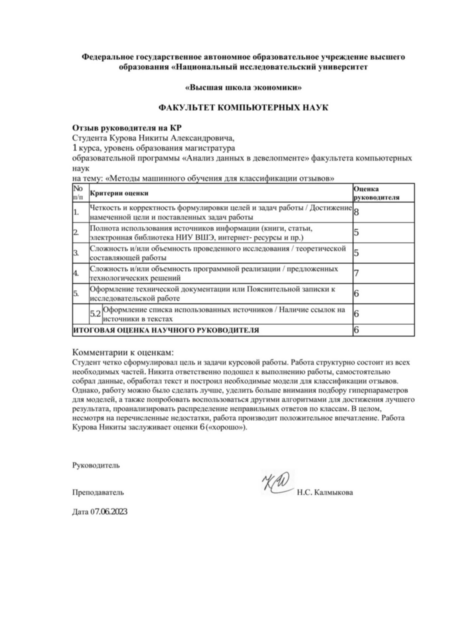

count of tables: 1


In [43]:
import requests
import base64
from io import BytesIO
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import cv2
import numpy as np
import uuid

preprocess_url = "http://localhost:9200/preprocess/pdf"
detect_url = "http://localhost:8000/detect"
pdf_file = {"file": open("../resources/pdf/test_document.pdf", "rb")}
pre_response = requests.post(preprocess_url, files=pdf_file)

if not pre_response.ok:
    print("Ошибка PreprocessService:", pre_response.status_code)
    exit()

images_b64 = pre_response.json()["images"]
print(f"Получено страниц: {len(images_b64)}")

first_image_b64 = images_b64[0]
img_bytes = BytesIO(base64.b64decode(first_image_b64))
img_pil = Image.open(img_bytes).convert("RGB")
img_pil = img_pil.filter(ImageFilter.BoxBlur(2))

file_name = f'../buf/{uuid.uuid4()}.jpeg'
img_pil.save(file_name, format="JPEG")

res = show_and_get_tables(file_name, True)

In [44]:
res[0]

,0,1,2,3,4
0,No п/и.,Критерии оценки.,Оценка\nруководителя,,
1,1.,Четкость и корректность формулировки целей и з...,8,,
2,2.,Полнота использования источников информации (к...,5,,
3,3.,Сложность и/или объемность проведенного исслед...,5,,
4,4.,"Сложность и ""многообъемность"" программной реал...",7,,
5,5.,"оформление технической документации и п. ""а"" п...",ЖРП.,6,
6,Для чего?,5.2,оформление списка использованных источников / ...,Юр. %.,6
7,ТЭЦ ООО «ОЦЕНКА НАУЧного РУКОВОДИТЕля»,6,,,


In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("bond005/ruT5-ASR-large", use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained("bond005/ruT5-ASR-large")

f:\GitHub\table-parser\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [24]:
from transformers import T5ForConditionalGeneration
from transformers import GenerationConfig
from transformers import T5Tokenizer
import torch

input_examples = [
    'Ззявка на номенклатурную единицу'
]

tokenizer_for_restoring = T5Tokenizer.from_pretrained('bond005/ruT5-ASR-large')
model_for_restoring = T5ForConditionalGeneration.from_pretrained('bond005/ruT5-ASR-large')
config_for_restoring = GenerationConfig.from_pretrained('bond005/ruT5-ASR-large')
if torch.cuda.is_available():
    model_for_restoring = model_for_restoring.cuda()

def restore_text(
    text: str, 
    tokenizer: T5Tokenizer, 
    config: GenerationConfig,
    model: T5ForConditionalGeneration
) -> str:
    if len(text) == 0:  # if an input text is empty, then we return an empty text too
        return ''
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 2.0 + 10)
    min_size = 3
    if x.input_ids.shape[1] <= min_size:
        return text
    out = model.generate(**x, generation_config=config, max_length=max_size)
    res = tokenizer.decode(out[0], skip_special_tokens=True).strip()
    return ' '.join(res.split())

for idx, val in enumerate(input_examples):
    restored = restore_text(val, tokenizer_for_restoring,
                            config_for_restoring, model_for_restoring)
    print('==========')
    print(f'Example {idx + 1}')
    print('==========')
    print('')
    print('ASR output before restoring:')
    print('')
    print(val)
    print('')
    print('After restoring:')
    print('')
    print(restored)
    print('')

Example 1

ASR output before restoring:

Ззявка на номенклатурную единицу

After restoring:

Скидка на номенклатурную единицу.

